## BCI ensemble processing

#### Libraries

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

import functions_py.fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))
colormap[10] = colormap[11]

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


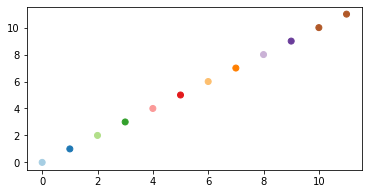

In [2]:
fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(6,3))

f1ax0.scatter(np.arange(0,12,1), np.arange(0,12,1), color=colormap)    
   

## Load benchmarking data

### Regrowth curves

In [3]:
# regrowth curves 
dfre = pd.read_csv('/global/homes/j/jneedham/DBEN/benchmarking_data/benchmark_regrowth_curves.csv')
dfre = dfre[dfre.Biome == 'Tropics']
#dfre.head(15)

# Bin_num here refers to time - these data are for plotting regrowth curves
# Columns are median, 10th and 90th percentiles

### Stand structure - nplant and AGB by size

In [4]:
# stand structure data 
dfss = pd.read_csv('/global/homes/j/jneedham/DBEN/benchmarking_data/benchmark_stand_structure.csv')
dfss = dfss[dfss.site == 'BCI']
#dfss.head(5)

### Equilibrium dynamics

In [5]:
# equilibrium dynamics
dfeq = pd.read_csv('/global/homes/j/jneedham/DBEN/benchmarking_data/benchmark_eq_dynamics.csv')
dfeq = dfeq[dfeq.site == 'BCI']
#dfeq.head(5)

In [6]:
# this function takes data that has monthly values and returns a single annual value, with 
# a mean that accounts for the number of days per month
def monthly_to_annual(array):
    """ calculate annual mean from monthly data, using unequal month lengths for noleap calendar.  
    originally written by Keith Lindsay."""
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

## FATES 

In [7]:
fates1 = '/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/bci_trendy_ensemble_1.E93ab10c892-F53b237c6.2024-05-16/run/bci_trendy_ensemble_1.E93ab10c892-F53b237c6.2024-05-16.h0.ensemble.sofar.nc'
fates1 = xr.open_dataset(fates1,  decode_times=False)

fates2 = '/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/bci_trendy_ensemble_2.E93ab10c892-F53b237c6.2024-05-16/run/bci_trendy_ensemble_2.E93ab10c892-F53b237c6.2024-05-16.h0.ensemble.sofar.nc'
fates2 = xr.open_dataset(fates2,  decode_times=False)

fates = xr.concat([fates1, fates2], dim='record')

print(fates.dims)



Frozen({'levgrnd': 15, 'levlak': 10, 'levdcmp': 15, 'levsoi': 10, 'fates_levscls': 16, 'record': 256, 'fates_levscag': 80, 'fates_levscpf': 64, 'fates_levcacls': 2, 'fates_levcapf': 8, 'fates_levage': 5, 'fates_levpft': 4, 'fates_levfuel': 6, 'fates_levcwdsc': 4, 'fates_levcan': 3, 'fates_levleaf': 30, 'fates_levcnlf': 90, 'fates_levcnlfpf': 360, 'fates_levheight': 6, 'fates_levscagpf': 320, 'fates_levagepft': 20, 'fates_levelem': 1, 'fates_levelpft': 4, 'fates_levelcwd': 4, 'fates_levelage': 5, 'fates_levagefuel': 30, 'fates_levcdsc': 32, 'fates_levcdpf': 128, 'fates_levcdam': 2, 'time': 3600, 'hist_interval': 2, 'lndgrid': 1})


In [8]:
nyears = int(len(fates.variables['time'])/12) 
time = fates.variables['time'] / 365.
print(nyears)


n_lat = len(fates.variables['lat'])
n_lon = len(fates.variables['lon'])

tave_start = (nyears-10)
tave_stop = nyears


cohort_size_bins = fates.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)
patch_age_bins = fates.variables['fates_levage'][:]

ninst = n_lon

300


### Regrowth curves - full ensemble and time series

''

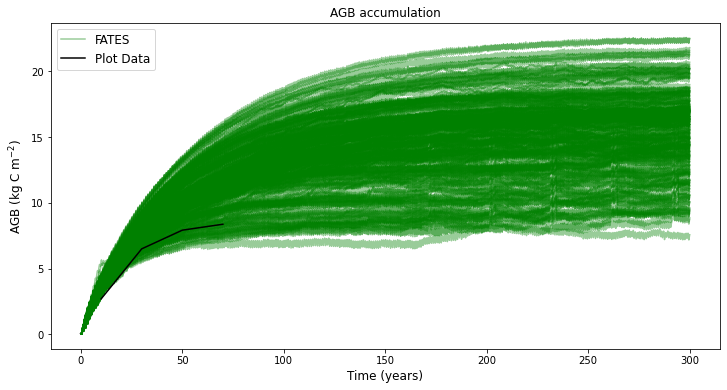

In [9]:
AGB = fates.FATES_VEGC_ABOVEGROUND

fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

for  i in range(0,ninst):
    if i == 0: 
        f1ax0.plot(time, AGB[i,:], color='green', label = 'FATES', alpha = 0.4)    
    else: 
        f1ax0.plot(time, AGB[i,:], color='green', alpha = 0.4)

f1ax0.set_title(r'AGB accumulation', fontsize = 12)
f1ax0.set_ylabel(r'AGB (kg C m$^{-2}$)', fontsize = 12)
f1ax0.set_xlabel(r'Time (years)', fontsize = 12)    
   
time_plot = dfre.bin_num
agb_plot = dfre.AGcwood_kgCm2_med

f1ax0.plot(time_plot, agb_plot, color='black', label = 'Plot Data')

f1ax0.legend(prop={'size':12})
;

### Equilibrium AGB

''

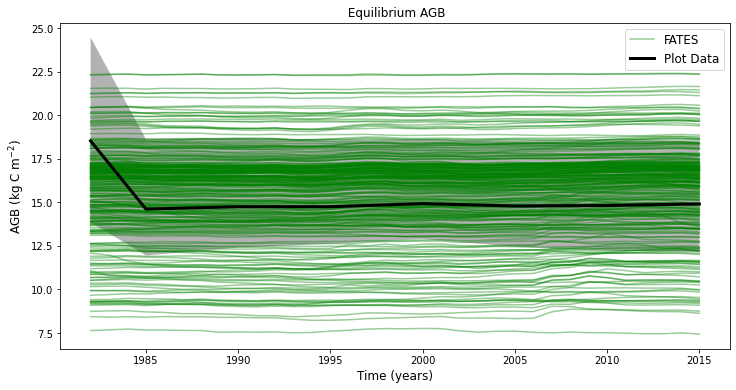

In [10]:
time_plot = list(dfeq.Year)
agb_plot = dfeq.AGB_kgCm2
agb_plot_lower = dfeq.AGB_lower_kgCm2
agb_plot_upper = dfeq.AGB_upper_kgCm2

eq_time = np.arange(time_plot[0], (time_plot[-1]+1), 1)
tstart = nyears-(len(eq_time))
tstop = nyears

AGB = monthly_to_annual(fates.FATES_VEGC_ABOVEGROUND)

fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

for  i in range(0,ninst):
    if i == 0: 
        f1ax0.plot(eq_time, AGB[i,tstart:tstop], color='green', label = 'FATES', alpha = 0.4)    
    else: 
        f1ax0.plot(eq_time, AGB[i,tstart:tstop], color='green', alpha = 0.4)

f1ax0.set_title(r' Equilibrium AGB', fontsize = 12)
f1ax0.set_ylabel(r'AGB (kg C m$^{-2}$)', fontsize = 12)
f1ax0.set_xlabel(r'Time (years)', fontsize = 12)    
   
f1ax0.plot(time_plot, agb_plot, color='black', label = 'Plot Data', linewidth=3)
f1ax0.fill_between(time_plot, agb_plot_lower, agb_plot_upper, alpha=0.6, facecolor='grey')

f1ax0.legend(prop={'size':12})
;

In [11]:
# dbh_classes_num are UPPER  bounds. Remove the  first size  bin
plot_sizebin = np.array(dfss.dbh_classes_num)
plot_sizebin_mids = (plot_sizebin[0:-1] + plot_sizebin[1:])/2
plot_sizebin_widths = plot_sizebin[1:] - plot_sizebin[:-1]
plot_nplant = dfss['nstem_size_ha.1']

# size bins are LOWER bounds. Remove the fist bin - but add an extra bin to catch trees over last bin edge
cohort_size_bins_ex = np.append(cohort_size_bins[1:], 250)
fates_sizebin_mids = (cohort_size_bins_ex[0:-1] + cohort_size_bins_ex[1:])/2
fates_sizebin_widths = cohort_size_bins_ex[1:] - cohort_size_bins_ex[:-1]

''

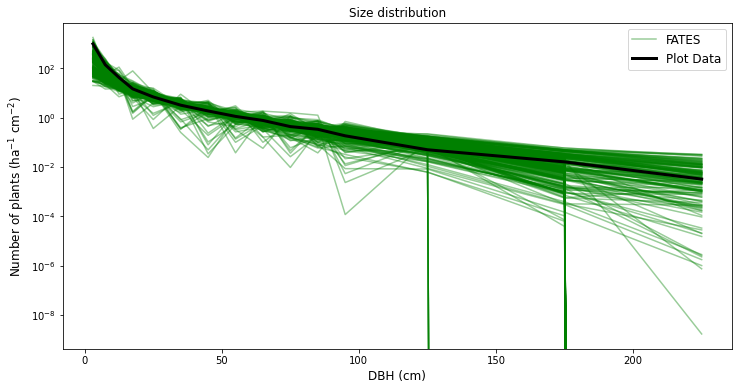

In [12]:
nplant = monthly_to_annual(fates.FATES_NPLANT_SZ)
nplant = np.squeeze(nplant.isel(time=slice(tave_start,tave_stop)).mean(dim='time')) * 10000 # convert to plants per ha (from m-2)

plot_sd = plot_nplant.iloc[1:]/plot_sizebin_widths
fates_sd = nplant[:,1:]/fates_sizebin_widths


fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

for  i in range(0,ninst):
    if i == 0: 
        f2ax0.plot(fates_sizebin_mids, fates_sd[i,:], color='green', 
                   label = 'FATES', alpha = 0.4)    
    else: 
        f2ax0.plot(fates_sizebin_mids, fates_sd[i,:], color='green', alpha = 0.4)

f2ax0.set_title(r'Size distribution', fontsize = 12)
f2ax0.set_ylabel(r'Number of plants (ha$^{-1}$ cm$^{-2}$)', fontsize = 12)
f2ax0.set_xlabel(r'DBH (cm)', fontsize = 12)    
       
f2ax0.plot(plot_sizebin_mids, plot_sd, color='black', 
           label = 'Plot Data', linewidth = 3)
f2ax0.set_yscale('log')
#f2ax0.set_xscale('log')

f2ax0.legend(prop={'size':12})
;

(256, 16)
(256, 16)


''

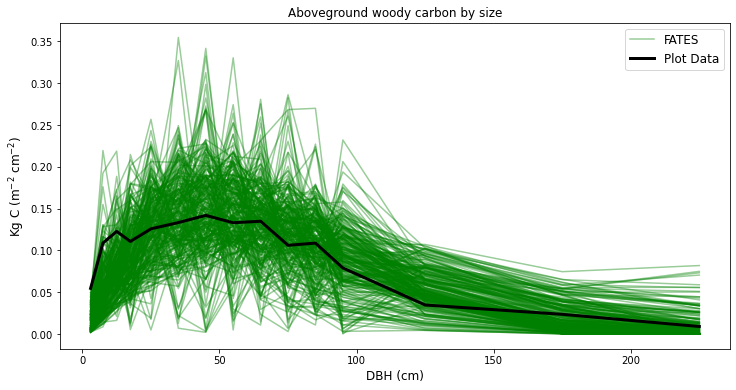

In [13]:
agb_frac = 0.6
WOODC = monthly_to_annual(fates.FATES_WOODC_SZ)
WOODC = np.squeeze(WOODC.isel(time=slice(tave_start, tave_stop)).mean(dim='time')) * agb_frac
print(WOODC.shape)
fates_agb_sd = WOODC[:,1:]/fates_sizebin_widths
print(WOODC.shape)

fig3, ((f3ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

for  i in range(0,ninst):
    if i == 0: 
        f3ax0.plot(fates_sizebin_mids, fates_agb_sd[i,:], color='green', 
                   label = 'FATES', alpha = 0.4)    
    else: 
        f3ax0.plot(fates_sizebin_mids, fates_agb_sd[i,:], color='green', alpha = 0.4)

f3ax0.set_title(r'Aboveground woody carbon by size', fontsize = 12)
f3ax0.set_ylabel(r'Kg C (m$^{-2}$ cm$^{-2}$)', fontsize = 12)
f3ax0.set_xlabel(r'DBH (cm)', fontsize = 12)    
   
#dfss_bci.head(10)    
    
plot_cwood_sz = dfss['AGB_size_kgCm.2']
plot_agb_sd = plot_cwood_sz[1:]/plot_sizebin_widths
    
f3ax0.plot(plot_sizebin_mids, plot_agb_sd, color='black', label = 'Plot Data', 
          linewidth=3)

f3ax0.legend(prop={'size':12})
;

## Pick out the best ones

#### Equilibrium AGB fit

In [14]:
# Mean equilibrium plot AGB
agb_plot_mu = np.mean(agb_plot)
print(agb_plot_mu)

# Mean equilibrium FATES AGB
AGB = monthly_to_annual(fates.FATES_VEGC_ABOVEGROUND)
agb_fates_mu = AGB.isel(time=slice(tave_start, tave_stop)).mean(dim='time')

# Find the ensemble members within 10% of equilibrium AGB
tmp = np.array(abs(agb_fates_mu - agb_plot_mu))
agb_eq_good = np.squeeze(np.where(tmp < (agb_plot_mu * 0.05)))[0]
print(agb_eq_good)

15.257159881062666
[  3  15  17  27  30  34  37  43  52  60  61  68  81  84  89  90  91 103
 105 108 118 128 130 133 136 141 142 149 154 156 162 179 181 182 183 186
 200 205 207 213 221 224 234 237]


#### AGB regrowth fit

In [15]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


In [16]:
AGB = np.squeeze(monthly_to_annual(fates.FATES_VEGC_ABOVEGROUND))

time_plot = dfre.bin_num
agb_plot = dfre.AGcwood_kgCm2_med

AGB_regrowth_timepoints = AGB[:,time_plot]

rmse_regrowth = []
for i in range(0,ninst): 
    rmse_regrowth.append(rmse(AGB_regrowth_timepoints[i,:], agb_plot))
    
regrowth_best = rmse_regrowth.index(min(rmse_regrowth))
print(regrowth_best)

118


#### Size distribution fit

In [17]:
rmse_sizedist = []
for i in range(0,ninst):
    rmse_sizedist.append(rmse(plot_sd, fates_sd[i,:]))
    
sizedist_best = rmse_sizedist.index(min(rmse_sizedist)) 
print(sizedist_best)

156


#### AGB by size fit

In [18]:
rmse_agb_dist = []
for i in range(0,ninst):
    rmse_agb_dist.append(rmse(plot_agb_sd, fates_agb_sd[i,:]))
    
agb_dist_best = rmse_agb_dist.index(min(rmse_agb_dist)) 
print(agb_dist_best)

67


#### Overall good runs?

In [19]:
good = np.concatenate((agb_eq_good, regrowth_best, sizedist_best, agb_dist_best), axis=None)
print(good)

[  3  15  17  27  30  34  37  43  52  60  61  68  81  84  89  90  91 103
 105 108 118 128 130 133 136 141 142 149 154 156 162 179 181 182 183 186
 200 205 207 213 221 224 234 237 118 156  67]


## AGB by PFT

In [20]:
AGB = monthly_to_annual(fates.FATES_VEGC_PF)

coex = []

for  i in range(0,len(good)):
    
    # percent total  biomass of each tree PFT
    AGBrec =  AGB.isel(record=good[i])
    AGBfinal = AGBrec.isel(time=nyears-1)
    total = AGBfinal.sum(dim=('fates_levpft'))
    pft1 = (AGBfinal.isel(fates_levpft=0)  / total ).values
    pft2 = (AGBfinal.isel(fates_levpft=1)  / total ).values
    pft3 = (AGBfinal.isel(fates_levpft=2)  / total ).values
     # make sure no PFT has more than 80% of biomass 
    if (pft1 < 0.8 and pft2 < 0.8  and pft3 < 0.8) :
        coex.append(good[i])
        
print(len(coex))        
    


15


[30, 37, 84, 90, 105, 128, 133, 142, 179, 182, 183, 186, 221, 234, 237]


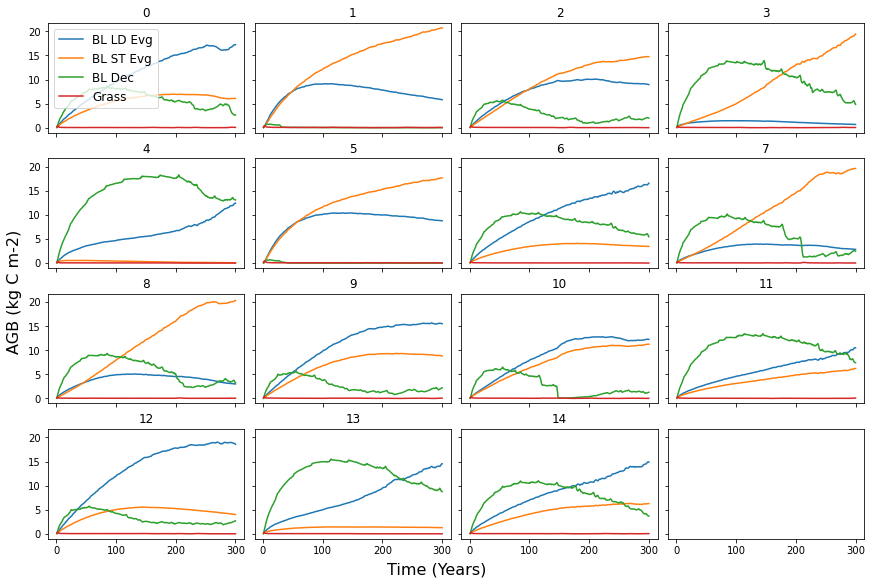

In [21]:
time = np.linspace(1,300,300)

fig1, axs = plt.subplots(nrows=4,ncols=4, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()
  
for i in range(0,len(coex)):    
    axs[i].plot(time, AGB[coex[i],:,0],label = 'BL LD Evg')  
    axs[i].plot(time, AGB[coex[i],:,1], label = 'BL ST Evg')   
    axs[i].plot(time, AGB[coex[i],:,2],  label = 'BL Dec')   
    axs[i].plot(time, AGB[coex[i],:,3],  label = 'Grass')  
    axs[i].set_title(i)
    if i == 0:
        axs[i].legend(prop={'size':12})

fig1.supxlabel(r'Time (Years)', fontsize=16)
fig1.supylabel(r'AGB (kg C m-2)', fontsize=16)

print(coex)

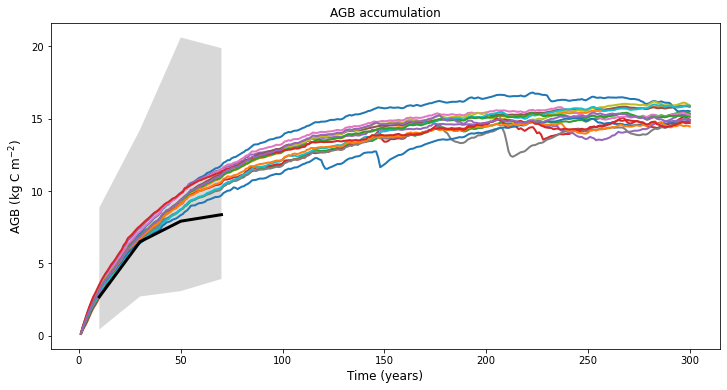

In [22]:
AGB = monthly_to_annual(fates.FATES_VEGC_ABOVEGROUND)

fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

for  i in range(0,len(coex)):
    f2ax0.plot(time, AGB[coex[i],:], label = i, linewidth=2)  

f2ax0.set_title(r'AGB accumulation', fontsize = 12)
f2ax0.set_ylabel(r'AGB (kg C m$^{-2}$)', fontsize = 12)
f2ax0.set_xlabel(r'Time (years)', fontsize = 12)    
   
#print(dfre.head(4) )   
time_plot = dfre.bin_num
agb_plot = dfre.AGcwood_kgCm2_med
agb_plot_l = dfre.AGcwood_kgCm2_10
agb_plot_u = dfre.AGcwood_kgCm2_90

f2ax0.plot(time_plot, agb_plot, color='black', label = 'Plot Data', linewidth=3)
f2ax0.fill_between(time_plot, agb_plot_l, agb_plot_u, alpha=0.3, facecolor='grey')

#f2ax0.legend(prop={'size':12})


''

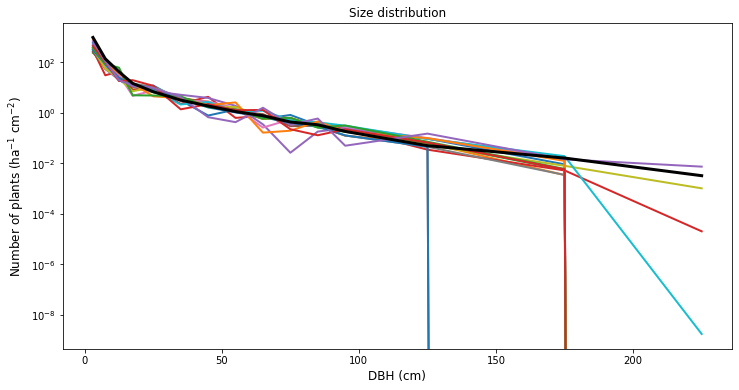

In [23]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

for  i in range(0,len(coex)):
        f2ax0.plot(fates_sizebin_mids, nplant[coex[i],1:]/fates_sizebin_widths,
                   label = i, linewidth=2)    
   
f2ax0.set_title(r'Size distribution', fontsize = 12)
f2ax0.set_ylabel(r'Number of plants (ha$^{-1}$ cm$^{-2}$)', fontsize = 12)
f2ax0.set_xlabel(r'DBH (cm)', fontsize = 12)    
       
f2ax0.plot(plot_sizebin_mids, plot_nplant.iloc[1:]/plot_sizebin_widths, color='black',
           label = 'Plot Data', linewidth=3)
f2ax0.set_yscale('log')

#f2ax0.legend(prop={'size':10})
;

''

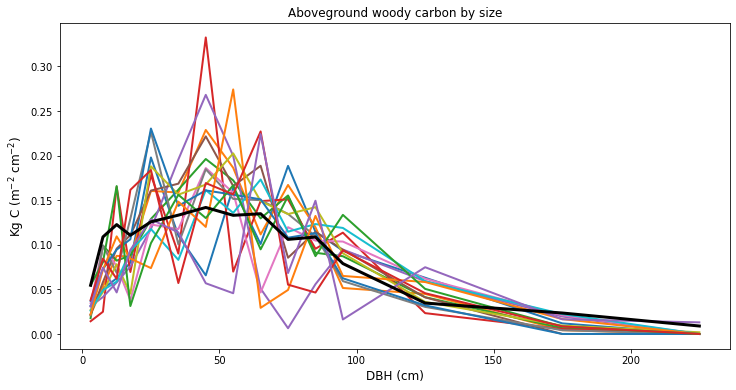

In [24]:
fig3, ((f3ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

for  i in range(0,len(coex)):
    f3ax0.plot(fates_sizebin_mids, fates_agb_sd[coex[i],:], 
               label = i,linewidth=2)    
    
f3ax0.set_title(r'Aboveground woody carbon by size', fontsize = 12)
f3ax0.set_ylabel(r'Kg C (m$^{-2}$ cm$^{-2}$)', fontsize = 12)
f3ax0.set_xlabel(r'DBH (cm)', fontsize = 12)    
   
plot_cwood_sz = dfss['AGB_size_kgCm.2']
    
f3ax0.plot(plot_sizebin_mids, plot_cwood_sz[1:]/plot_sizebin_widths, color='black',
           label = 'Plot Data', linewidth=3)

#f3ax0.legend(prop={'size':12})
;

In [25]:
### Equilibrium AGB in the data

''

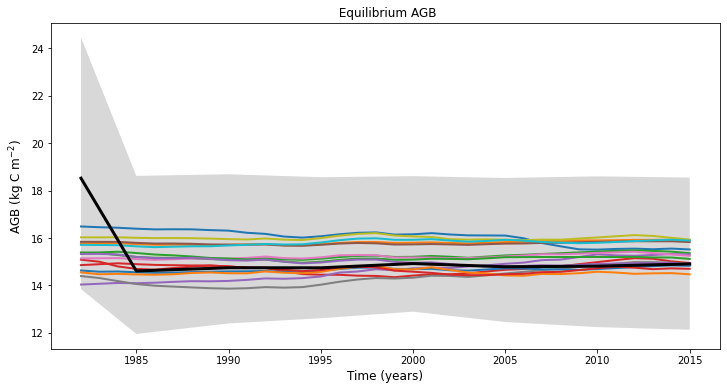

In [26]:
time_plot = list(dfeq.Year)
agb_plot = dfeq.AGB_kgCm2
agb_plot_lower = dfeq.AGB_lower_kgCm2
agb_plot_upper = dfeq.AGB_upper_kgCm2

eq_time = np.arange(time_plot[0], (time_plot[-1]+1), 1)
tstart = nyears-(len(eq_time))
tstop = nyears

fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

for  i in range(0,len(coex)):
     f1ax0.plot(eq_time, AGB[coex[i],tstart:tstop], label = i, linewidth=2)    
   
f1ax0.set_title(r' Equilibrium AGB', fontsize = 12)
f1ax0.set_ylabel(r'AGB (kg C m$^{-2}$)', fontsize = 12)
f1ax0.set_xlabel(r'Time (years)', fontsize = 12)    
   
f1ax0.plot(time_plot, agb_plot, color='black', label = 'Plot Data', linewidth=3)
f1ax0.fill_between(time_plot, agb_plot_lower, agb_plot_upper, alpha=0.3, facecolor='grey')

#f1ax0.legend(prop={'size':10})
;

##  Load the best ensemble member  

### first look at coexistence

In [27]:
rec = 2

vegc = monthly_to_annual(fates.FATES_VEGC_PF)
vegc = vegc.isel(record=coex[rec])


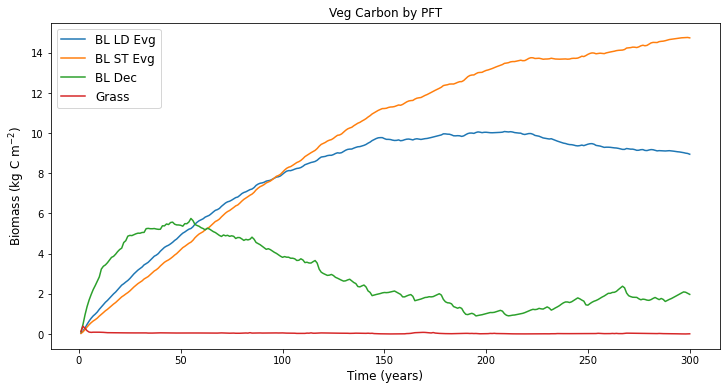

In [28]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

f2ax0.plot(time, vegc.isel(fates_levpft=0),label = 'BL LD Evg')  
f2ax0.plot(time, vegc.isel(fates_levpft=1), label = 'BL ST Evg')   
f2ax0.plot(time, vegc.isel(fates_levpft=2),  label = 'BL Dec')   
f2ax0.plot(time, vegc.isel(fates_levpft=3),  label = 'Grass')

f2ax0.set_title(r'Veg Carbon by PFT', fontsize = 12)
f2ax0.set_ylabel(r'Biomass (kg C m$^{-2}$)', fontsize = 12)
f2ax0.set_xlabel(r'Time (years)', fontsize = 12)    
   

f2ax0.legend(prop={'size':12})


(300, 16, 1)
(16,)


''

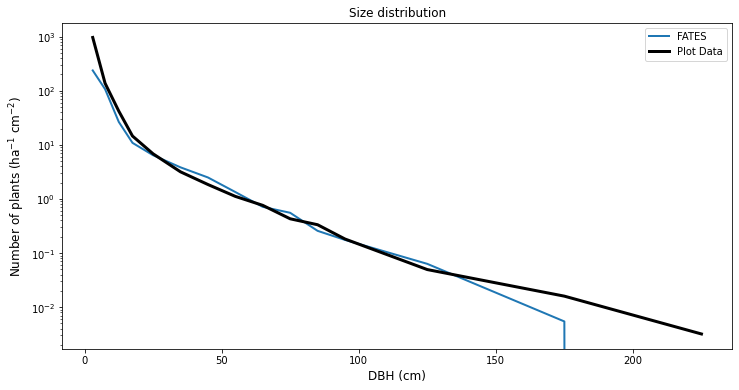

In [29]:
nplant = fates.FATES_NPLANT_SZ.isel(record=coex[rec])
nplant = monthly_to_annual(nplant)
print(nplant.shape)

nplant = np.squeeze(nplant.isel(time=slice(tave_start,tave_stop)).mean(dim='time')) * 10000 # convert to plants per ha (from m-2)
print(nplant.shape)

fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

f2ax0.plot(fates_sizebin_mids, nplant[1:]/fates_sizebin_widths, 
                   label = 'FATES', linewidth=2)    
   
f2ax0.set_title(r'Size distribution', fontsize = 12)
f2ax0.set_ylabel(r'Number of plants (ha$^{-1}$ cm$^{-2}$)', fontsize = 12)
f2ax0.set_xlabel(r'DBH (cm)', fontsize = 12)    
       
f2ax0.plot(plot_sizebin_mids, plot_nplant.iloc[1:]/plot_sizebin_widths, color='black',
           label = 'Plot Data', linewidth=3)
f2ax0.set_yscale('log')

f2ax0.legend(prop={'size':10})
;

''

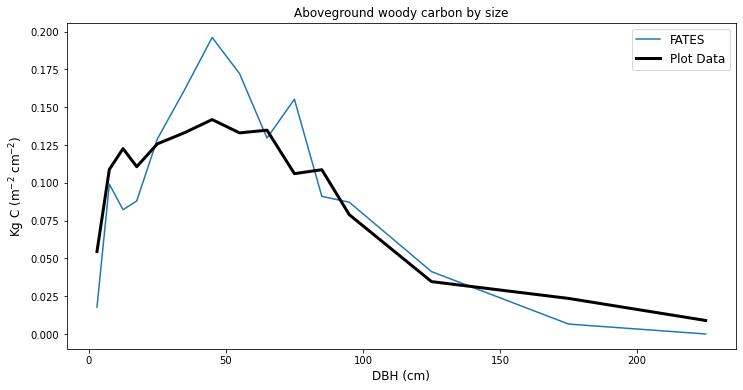

In [30]:
agb_frac = 0.6
woodc = fates.FATES_WOODC_SZ.isel(record=coex[rec])
woodc = monthly_to_annual(woodc)

WOODC = np.squeeze(woodc.isel(time=slice(tave_start, tave_stop)).mean(dim='time')) * agb_frac

fates_agb_sd = WOODC[1:]/fates_sizebin_widths


fig3, ((f3ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

f3ax0.plot(fates_sizebin_mids, fates_agb_sd, 
                   label = 'FATES')    
   
f3ax0.set_title(r'Aboveground woody carbon by size', fontsize = 12)
f3ax0.set_ylabel(r'Kg C (m$^{-2}$ cm$^{-2}$)', fontsize = 12)
f3ax0.set_xlabel(r'DBH (cm)', fontsize = 12)    
      
plot_cwood_sz = dfss['AGB_size_kgCm.2']
plot_agb_sd = plot_cwood_sz[1:]/plot_sizebin_widths
    
f3ax0.plot(plot_sizebin_mids, plot_agb_sd, color='black', label = 'Plot Data', 
          linewidth=3)

f3ax0.legend(prop={'size':12})
;

''

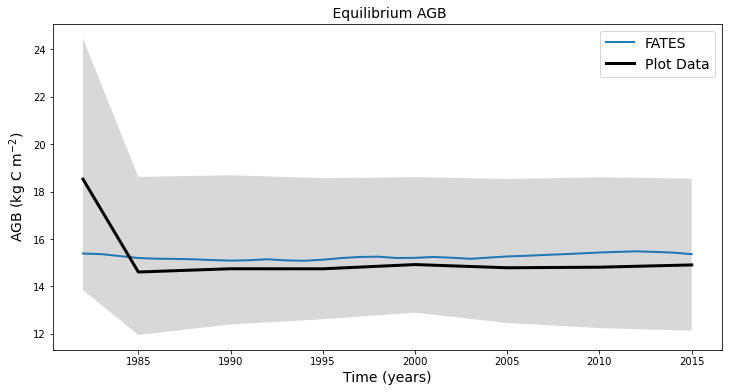

In [31]:
AGB = fates.FATES_VEGC_ABOVEGROUND.isel(record=coex[rec])
AGB = monthly_to_annual(AGB)

eq_time = np.arange(time_plot[0], (time_plot[-1]+1), 1)
tstart = nyears-(len(eq_time))
tstop = nyears

fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

f1ax0.plot(eq_time, AGB[tstart:tstop], label = 'FATES', linewidth=2)    
   
f1ax0.set_title(r' Equilibrium AGB', fontsize = 14)
f1ax0.set_ylabel(r'AGB (kg C m$^{-2}$)', fontsize = 14)
f1ax0.set_xlabel(r'Time (years)', fontsize = 14)    
   
f1ax0.plot(time_plot, agb_plot, color='black', label = 'Plot Data', linewidth=3)
f1ax0.fill_between(time_plot, agb_plot_lower, agb_plot_upper, alpha=0.3, facecolor='grey')

f1ax0.legend(prop={'size':14})
;

In [32]:
print(coex[rec])

84
